## Bandit Problems

In this notebook you will plot the average reward and the percentage of optimal actions up to time $t$,
for three $10$-armed bandit policies:

- $\epsilon$-Greedy
- Optimistic Greedy
- UCB

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import ipywidgets as widgets
from IPython.display import display, clear_output

Matplotlib is building the font cache; this may take a moment.


## Run Experiments with RlGlue

RLGlue is a Python package that is included in the folder you downloaded.

With it you connect an RL agent to an environment and conduct an experiment to test the agent's ability to accumulate reward in the environment.

In [3]:
import sys
import os
import inspect

#module_path = os.path.abspath('RlGlue') 
#sys.path.insert(0, module_path) 

from rlglue.rl_glue import RLGlue
from main_agent import Agent
from ten_arm_env import Environment


#### Our own `argmax`

In case of ties `np.argmax` always picks the first index.

We want to pick a random index to encourage exploration.

In [4]:
# Code adapted from University of Alberta Reinforcement Learning Coursera course.

def argmax(q_values):
    """
    Takes in a list of q_values and returns the index of the item 
    with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top_value = float("-inf")
    ties = []
    
    for i in range(len(q_values)):
        # if a value in q_values is greater than the highest value update top and reset ties to zero
        # if a value is equal to top value add the index to ties
        # return a random selection from ties.
        # your code here
        if q_values[i] > top_value:
            ties = [i]
            top_value = q_values[i]
        elif q_values[i] == top_value:
            ties.append(i)
        
    return np.random.choice(ties)

### Greedy Agent

This class represents an agent that follows the greedy policy.

It inherits from Agent, defined in agent.py in this folder. Get familiar with Agent, in particular its instance variables (`self.foo`) and the methods `start`, `step`, and `end`, which the RlGlue API demands of every agent.

#### Incremental $Q$ updates

Notice that `q_values[a]` represents $Q_t(a)$ for the current time $t$. We normally think of this as the average reward so far. If we have sampled an arm $n-1$ times the average for that arm is

$$
Q_{n+1} = \frac{1}{n}(R_1(a) + R_2(a) + \ldots + R_{n}(a)),
$$

but the code computes the same thing incrementally using $Q_n$ in Section 2.4 (you can check the math):

$$
Q_{n+1} = Q_n + \frac{1}{n}(R_n - Q_n).
$$

In the code, $n$ is `self.arm_count`.

In [5]:
# Code adapted from University of Alberta Reinforcement Learning Coursera course.

class GreedyAgent(Agent):
    def agent_step(self, reward, observation=None, extra=None):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent recieved from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this as you will not use it
                              until future lessons
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        a = self.last_action
        self.arm_count[a] += 1
        step_size = 1.0/self.arm_count[a]
        self.q_values[a] = self.q_values[a] + step_size*(reward - self.q_values[a])
        
        current_action = argmax(self.q_values)        
    
        self.last_action = current_action
        
        return current_action
 

### The Environment and the Experiment

The environment, a 10-armed bandit, is implemented in `ten_arm_env.py` in this folder.

The RlGlue object initialized in the next cell conducts the experiment.

Notice that the return value of `rl_glue.step()` is an `Interaction` object, defined in `rl_glue.py`. This is a class that just contains data variables, like a C `struct`.

Change `run%50 == 50` to `run%50 == 0` to see plots of individual runs.

[ 1.76405235  0.40015721  0.97873798  2.2408932   1.86755799 -0.97727788
  0.95008842 -0.15135721 -0.10321885  0.4105985 ]


100%|██████████| 200/200 [00:01<00:00, 118.06it/s]


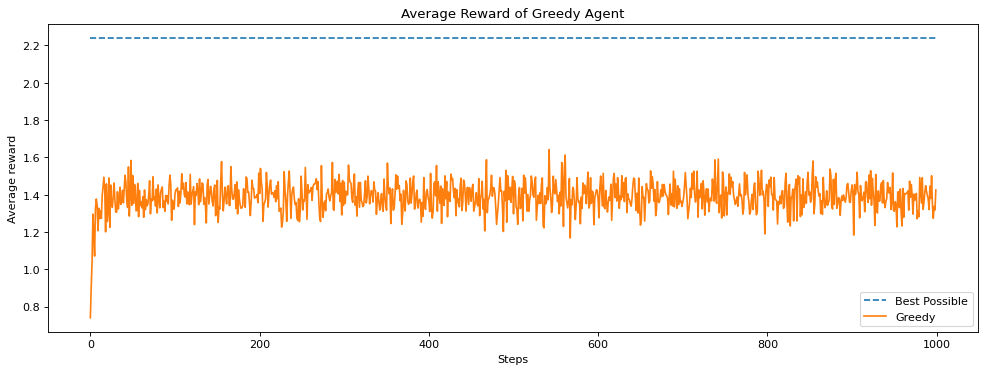

In [6]:
# Code adapted from University of Alberta Reinforcement Learning Coursera course.

num_runs = 200                    # The number of times we run the experiment
num_steps = 1000                  # The number of pulls of each arm the agent takes
np.random.seed(0)                 # For some reason successive runs give the same arms!?
env = Environment()               # We set what environment we want to use to test
agent = GreedyAgent()             # We choose what agent we want to use
env.env_init({})                # We pass the environment the information it needs. In this case nothing.
best_possible = np.max(env.arms)
print(env.arms)

rewards = np.zeros((num_runs, num_steps))
for run in tqdm(range(num_runs)):           # tqdm is what creates the progress bar below
    np.random.seed(run)                     # the environment behaves differently each run
    agent.agent_init({"num_actions": 10, 
                "initial_value": 0.0})      # the agent restarts with 10 arms and 0.0 Q_t's every run
    
    rl_glue = RLGlue(agent, env)            # Creates a new RLGlue experiment with the env and agent we chose above
    rl_glue.rl_start()                         # We start the experiment
        
    for i in range(num_steps):
        interaction = rl_glue.rl_step()        # The environment and agent take a step and return
                                            # the reward and action taken.
        rewards[run, i] = interaction.r
        
    if run%50 == 50:
        plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
        plt.plot([best_possible for _ in range(num_steps)], linestyle="--")
        plt.plot(rewards[run, :])
        plt.legend(["Best Possible", "Greedy"])
        plt.title("Average Reward of Greedy Agent")
        plt.xlabel("Steps")
        plt.ylabel("Average reward")
        #plt.ylim((0,4))
        plt.show()
            
        
        #print(agent.q_values)

greedy_scores = np.mean(rewards, axis=0)
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([best_possible for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.legend(["Best Possible", "Greedy"])
plt.title("Average Reward of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
#plt.ylim((0,4))
plt.show()
#print(rewards)

## Coding Problems

### Problem 1 - $\epsilon$-Greedy

- Define the EpsilonGreedyAgent class on the model of GreedyAgent. 
- Set the agent's $\epsilon$ before conducting the experiment, using `agent_info` and the `Agent` `init()` method.
- Duplicate Figure 2.2 in the book (both graphs).

Comment here on your results:

In [ ]:
# EpsilonGreedyAgent definition code
class EpsilonGreedyAgent(GreedyAgent):
    def agent_start(self, observation):
    # choose either exploration or explotation
        if np.random.rand() < self.epsilon:
            # exploration
            a = np.random.choice(self.num_actions)
        else:
            # greedy - explotation
            a = argmax(self.q_values)
        self.last_action = a
        return a

    def agent_step(self, reward, observation, extra=None):
        # inherit agent_steps form GreedyAgent
        greedy_action = super().agent_step(reward, observation, extra)

        # choose either exploration or explotation
        if np.random.rand() < self.epsilon:
            # explore
            self.last_action = np.random.choice(self.num_actions)
        else:
            # exploit!!
            self.last_action = greedy_action
        return self.last_action


In [ ]:
# setting up for 10-armed bandit experiment
num_runs = 2000     
num_steps = 1000    
epsilons = [0.0, 0.01, 0.1] # The epsilon values for greedy and epsilon-greedy agents

# dictionaries for the values of y and x axes of the plot
avg_rewards = {} 
pct_optimal = {} 

for eps in epsilons:

    # Initialize reward and optimal action arrays
    rewards = np.zeros((num_runs, num_steps))
    optimal = np.zeros((num_runs, num_steps))

    # adapted from GreedyAgent code above
    for run in tqdm(range(num_runs)):           # tqdm is what creates the progress bar below
        np.random.seed(run)                     # the environment behaves differently each run
        
        agent = EpsilonGreedyAgent()

        # Initialize Greedy and Optimistic Greedy agents
        agent.agent_init({
            "num_actions": 10,
            "epsilon": eps,
            "initial_value": 0.0
        })

        env = Environment()               # We set what environment we want to use to test
        env.env_init({})    # We pass the environment the information it needs. In this case nothing.
        best_action = np.argmax(env.arms)
        
        rl_glue = RLGlue(agent, env)            # Creates a new RLGlue experiment with the env and agent we chose above
        rl_glue.rl_start()                         # We start the experiment
            
        for i in range(num_steps):
            interaction = rl_glue.rl_step()        # The environment and agent take a step and return
                                                # the reward and action taken.
            rewards[run, i] = interaction.r
            optimal[run, i] = (interaction.a == best_action) # calculate optimal action

    avg_rewards[eps] = rewards.mean(axis=0)
    pct_optimal[eps] = optimal.mean(axis=0) * 100

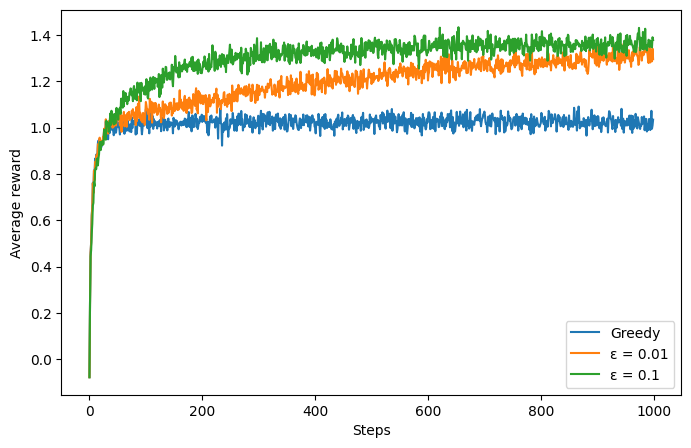

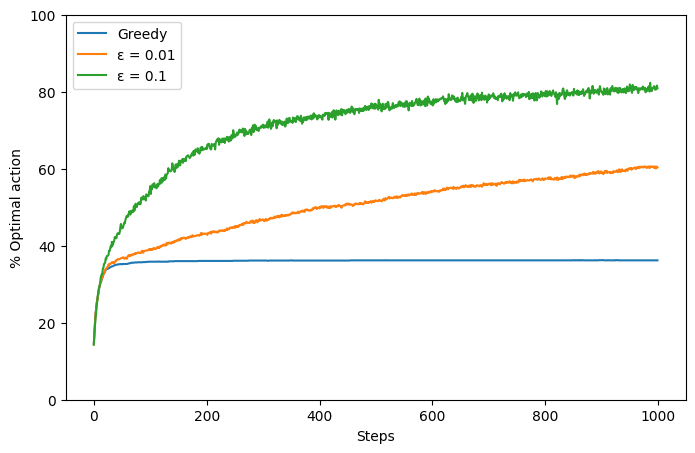

In [39]:
# Plot results similar to the ones in the book
labels = ["Greedy", "ε = 0.01", "ε = 0.1"]
#  Average reward figure
plt.figure(figsize=(8,5))
for eps, label in zip(epsilons, labels):
    plt.plot(avg_rewards[eps], label=label)
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.legend()
plt.show()

# % optimal action figure
plt.figure(figsize=(8,5))
for eps, label in zip(epsilons, labels):
    plt.plot(pct_optimal[eps], label=label)
plt.xlabel("Steps")
plt.ylabel("% Optimal action")
plt.ylim(0, 100)
plt.legend()
plt.show()

### Problem 2 - OptimisticGreedy

- Test an Optimistic Greedy agent using the GreedyAgent class. 
- Duplicate Figure 2.3 in the book (including the $\epsilon$-Greedy plot).

Comment here on your results:

In [51]:
# Optimistic Greedy experiment code

class OptimisticGreedyAgent(GreedyAgent):
    def agent_init(self, agent_info={}):
        """
        agent_info should contain:
            - num_actions (int)
            - initial_value (float, optimistic Q init)
        """
        self.num_actions = agent_info.get("num_actions")
        self.initial_value = agent_info.get("initial_value", 0.0)

        # Initialize all action values optimistically
        self.q_values = np.ones(self.num_actions) * self.initial_value
        self.action_counts = np.zeros(self.num_actions)
        self.last_action = None

    def agent_start(self, observation=None):
        """
        First step of the agent: choose action greedily from optimistic q_values.
        """
        a = argmax(self.q_values)   # greedy choice with optimistic initialization
        self.last_action = a
        return a

    def agent_step(self, reward, observation=None, extra=None):
        """
        Update estimates and choose next greedy action.
        """
        a = self.last_action
        self.arm_count[a] += 1
        step_size = 1.0 / self.arm_count[a]
        self.q_values[a] += step_size * (reward - self.q_values[a])

        # Always greedy after updating
        current_action = argmax(self.q_values)
        self.last_action = current_action
        return current_action

In [52]:
# empty dictionaries for the values of y and x axes of the plot
avg_rewards = {} 
pct_optimal = {} 

rewards = np.zeros((num_runs, num_steps))
optimal = np.zeros((num_runs, num_steps))
for run in tqdm(range(num_runs)):           # tqdm is what creates the progress bar below
        np.random.seed(run)                     # the environment behaves differently each run
        
        agent = EpsilonGreedyAgent()

        # Initialize Greedy and Optimistic Greedy agents
        agent.agent_init({
            "num_actions": 10,
            "epsilon": 0.1,
            "initial_value": 0.0
        })

        env = Environment()               # We set what environment we want to use to test
        env.env_init({})    # We pass the environment the information it needs. In this case nothing.
        best_action = np.argmax(env.arms)
        
        rl_glue = RLGlue(agent, env)            # Creates a new RLGlue experiment with the env and agent we chose above
        rl_glue.rl_start()                         # We start the experiment
            
        for i in range(num_steps):
            interaction = rl_glue.rl_step()        # The environment and agent take a step and return
                                                # the reward and action taken.
            rewards[run, i] = interaction.r
            optimal[run, i] = (interaction.a == best_action) # calculate optimal action

avg_rewards["Realistic, ε-greedy"] = rewards.mean(axis=0)
pct_optimal["Realistic, ε-greedy"] = optimal.mean(axis=0) * 100

# --- Optimistic Greedy Agent ---
rewards = np.zeros((num_runs, num_steps))
optimal = np.zeros((num_runs, num_steps))

for run in tqdm(range(num_runs)):
    np.random.seed(run)

    agent = OptimisticGreedyAgent()
    agent.agent_init({
        "num_actions": 10,
        "initial_value": 5.0   # or whatever optimistic value you want
    })

    env = Environment()
    env.env_init({})
    best_action = np.argmax(env.arms)

    rl_glue = RLGlue(agent, env)
    rl_glue.rl_start()

    for i in range(num_steps):
        interaction = rl_glue.rl_step()
        rewards[run, i] = interaction.r
        optimal[run, i] = (interaction.a == best_action)

avg_rewards["Optimistic Greedy"] = rewards.mean(axis=0)
pct_optimal["Optimistic Greedy"] = optimal.mean(axis=0) * 100

100%|██████████| 2000/2000 [00:17<00:00, 112.61it/s]


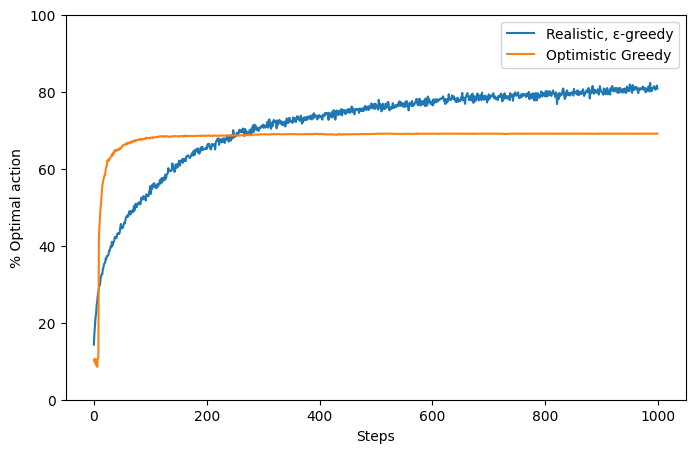

In [49]:
# plot

# % optimal action figure
plt.figure(figsize=(8,5))
for label in pct_optimal.keys():
    plt.plot(pct_optimal[label], label=label)
plt.xlabel("Steps")
plt.ylabel("% Optimal action")
plt.ylim(0, 100)
plt.legend()
plt.show()

### Problem 3 - UCB

- Define the UCBAgent class on the model of the GreedyAgent class. Do you need to override other methods besides `step`? Do you need to add instance variables (`self.foo`) to the class?
- Duplicate Figure 2.4 in the book (including the $\epsilon$-Greedy plot).

In [11]:
# UCBAgent definition code

In [12]:
# UCBAgent experiment code

## Discussion Questions

You may collaborate on these questions. Please list your collaborators for each problem. 

### Exercise 2.2

**Answer**:

The time steps this most definitely occured are the ones where the most optimal (greedy) option at that step is not chosen. The only step this happens at is at t = 5. At t = 5, estimated q values of actions are [-1, 2, 0, 0]. Therefore, a greedy algorithm would have chosen the optimal which is action 2. However, action 3 is chosen. All the other times, it might be greedy or exploration as the optimal one might have been chosen by either so we can't know for certain.


### Exercise 2.3

**Answer:** Answering this question requires taking into account the dilemma of exploring and explotation. When we choose a larger ε(0.1) value, we will be exploring more; when we choose a smaller ε value (0.01) we will exploit more. In the long run, we would want to exploit the best option known to us at that moment rather than risking and exploring random options. To answer quantitively, we will choose the best option with 1 − ε probability. So having the smaller ε of 0.01 will give a larger cumulative reward in the long run due to the optimal action probability of 0.99 rather than 0.9. However, the book suggests mixing high and low ε values to get a better result in the long-run, reducing the value over time to get the best of both high and low values.


### Exercise 2.8

**Answer:**


The spike at step 11 happens because, after trying each of the 10 arms once, The exploration term for all arms is similar (N_t(a) = 1). Thus, UCB chooses the empirically best-looking arm (acts greedy) and so the expected reward temporarily jumps up because we chose the best action at the time.

The drop afterward happens because UCB must keep exploring under-sampled arms, which means the reward from greedy actions is lacking temporarily. 

The subsequent dip due to exploring other arms is more aggressive with a larger c since the agent is forced away from the best-looking arm more strongly, lowering the average reward more drastically.

